In [1]:
import geopandas as gpd
from pystac_client import Client
from get_bounding_box import get_bounding_box
import stackstac
import pyproj

In [2]:
patillas_shoreline = gpd.read_file('../data/patillas_sample/vector/patillas_shoreline.shp')
patillas_shoreline

,OBJECTID,contour_m,Shape_Leng,Shape_Area,geometry
0,1.0,67.550003,21828.075344,1.203714e+06,"POLYGON ((242914.395 221850.983, 242914.450 22..."


In [3]:
wgs84 = pyproj.CRS('EPSG:4326')
bounding_box = get_bounding_box(patillas_shoreline, buffer_size=100, target_crs=wgs84)
bounding_box_values = [x for x in bounding_box.bounds.values[0]]
bounding_box_values

[-66.03383551972162,
 18.016611173645085,
 -66.00959436008657,
 18.031244923143596]

In [4]:
aws_stac_url = "https://earth-search.aws.element84.com/v0"
catalog = Client.open(aws_stac_url)

In [5]:
%%time
collections = ["sentinel-s2-l2a-cogs"]
items = catalog.search(collections=collections, bbox=bounding_box_values, datetime="2020-06-01/2021-06-01").get_all_items()
len(items)

Wall time: 3.65 s


150

In [6]:
%%time
stack = stackstac.stack(items)

Wall time: 128 ms


In [7]:
stack

,Array,Chunk
Bytes,4.27 TiB,8.00 MiB
Shape,"(150, 17, 20976, 10980)","(1, 1, 1024, 1024)"
Count,594381 Tasks,589050 Chunks
Type,float64,numpy.ndarray


In [8]:
%%time
lowcloud = stack[stack["eo:cloud_cover"] < 10]
rgb = lowcloud.sel(band=["B04", "B03", "B02"])
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

C:\Users\grego\anaconda3\envs\GlintSolar\lib\site-packages\dask\array\slicing.py:647: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))


Wall time: 1.67 s


In [9]:
monthly

,Array,Chunk
Bytes,66.92 GiB,8.00 MiB
Shape,"(13, 3, 20976, 10980)","(1, 1, 1024, 1024)"
Count,1094658 Tasks,9009 Chunks
Type,float64,numpy.ndarray


In [10]:
minx, miny, maxx, maxy = bounding_box.to_crs(monthly.crs).bounds.values[0]
minx, miny, maxx, maxy

(814068.3049055755, 1994545.2970037744, 816655.8468355149, 1996195.9244192585)

In [11]:
aoi = monthly.sel(x=slice(minx, maxx), y=slice(maxy, miny))
aoi

<xarray.DataArray 'stackstac-6de71e5a70ff3a129a4675eaf7d9a535' (time: 13, band: 3, y: 165, x: 259)>
dask.array<getitem, shape=(13, 3, 165, 259), dtype=float64, chunksize=(1, 1, 165, 259), chunktype=numpy.ndarray>
Coordinates:
  * time                    (time) datetime64[ns] 2020-06-01 ... 2021-06-01
  * band                    (band) <U8 'B04' 'B03' 'B02'
  * x                       (x) float64 8.141e+05 8.141e+05 ... 8.166e+05
  * y                       (y) float64 1.996e+06 1.996e+06 ... 1.995e+06
    instruments             <U3 'msi'
    proj:epsg               int32 32619
    sentinel:utm_zone       int32 19
    sentinel:latitude_band  <U1 'Q'
    view:off_nadir          int32 0
    gsd                     (band) object 10 10 10
    constellation           <U10 'sentinel-2'
    title                   (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name             (band) object 'red' 'green' 'blue'
    center_wavelength       (band) object 0.6645 0.56 0.4966
    full_width_half_max     (band) object 0.038 0.045 0.098
    epsg                    int32 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(799980.0, 1890240.0, 909780.0...
    crs:         epsg:32619
    transform:   | 10.00, 0.00, 799980.00|\n| 0.00,-10.00, 2100000.00|\n| 0.0...
    resolution:  10.0

In [12]:
%%time
data = aoi.compute()

Wall time: 20min 45s


In [13]:
data

<xarray.DataArray 'stackstac-6de71e5a70ff3a129a4675eaf7d9a535' (time: 13, band: 3, y: 165, x: 259)>
array([[[[2788. , 2676. , 2596. , ..., 4964. , 4984. , 4992. ],
         [2884. , 2686. , 2584. , ..., 4992. , 5024. , 5008. ],
         [2812. , 2644. , 2476. , ..., 4996. , 4928. , 4904. ],
         ...,
         [2432. , 2466. , 2396. , ...,  382. ,  328. ,  339. ],
         [2372. , 2476. , 2494. , ...,  310. ,  306. ,  328. ],
         [2286. , 2476. , 2580. , ...,  288. ,  310. ,  276. ]],

        [[2756. , 2714. , 2706. , ..., 5260. , 5180. , 5244. ],
         [2976. , 2846. , 2732. , ..., 5244. , 5220. , 5268. ],
         [3066. , 2842. , 2684. , ..., 5260. , 5304. , 5308. ],
         ...,
         [2612. , 2518. , 2396. , ...,  702. ,  656. ,  628. ],
         [2510. , 2544. , 2508. , ...,  611. ,  658. ,  663. ],
         [2424. , 2536. , 2590. , ...,  554. ,  675. ,  606. ]],

        [[2562. , 2562. , 2514. , ..., 5660. , 5584. , 5624. ],
         [2786. , 2788. , 2732. , ..., 5596. , 5508. , 5552. ],
         [3098. , 2890. , 2768. , ..., 5480. , 5556. , 5596. ],
         ...,
...
         ...,
         [ 527.5,  570. ,  540.5, ..., 2206. , 2079. , 2102. ],
         [ 543.5,  561.5,  540. , ..., 2229. , 2145. , 2086. ],
         [ 646. ,  636. ,  608. , ..., 2166. , 2106. , 2044. ]],

        [[4814. , 4566. , 4328. , ..., 4232. , 3949. , 3529. ],
         [4886. , 4666. , 4436. , ..., 4378. , 4210. , 3753. ],
         [5136. , 4900. , 4710. , ..., 4378. , 4286. , 3791. ],
         ...,
         [ 693. ,  705. ,  714.5, ..., 2488. , 2348. , 2267. ],
         [ 675. ,  695. ,  687.5, ..., 2518. , 2384. , 2374. ],
         [ 742. ,  756.5,  725.5, ..., 2443. , 2359. , 2331. ]],

        [[4828. , 4612. , 4386. , ..., 4018. , 3879. , 3584. ],
         [4964. , 4732. , 4474. , ..., 4338. , 3957. , 3550. ],
         [5064. , 4896. , 4646. , ..., 4490. , 4222. , 3749. ],
         ...,
         [ 628. ,  648.5,  628. , ..., 2550. , 2371. , 2172. ],
         [ 639. ,  622. ,  605. , ..., 2600. , 2425. , 2297. ],
         [ 671.5,  689.5,  613. , ..., 2598. , 2479. , 2367. ]]]])
Coordinates:
  * time                    (time) datetime64[ns] 2020-06-01 ... 2021-06-01
  * band                    (band) <U8 'B04' 'B03' 'B02'
  * x                       (x) float64 8.141e+05 8.141e+05 ... 8.166e+05
  * y                       (y) float64 1.996e+06 1.996e+06 ... 1.995e+06
    instruments             <U3 'msi'
    proj:epsg               int32 32619
    sentinel:utm_zone       int32 19
    sentinel:latitude_band  <U1 'Q'
    view:off_nadir          int32 0
    gsd                     (band) object 10 10 10
    constellation           <U10 'sentinel-2'
    title                   (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name             (band) object 'red' 'green' 'blue'
    center_wavelength       (band) object 0.6645 0.56 0.4966
    full_width_half_max     (band) object 0.038 0.045 0.098
    epsg                    int32 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(799980.0, 1890240.0, 909780.0...
    crs:         epsg:32619
    transform:   | 10.00, 0.00, 799980.00|\n| 0.00,-10.00, 2100000.00|\n| 0.0...
    resolution:  10.0

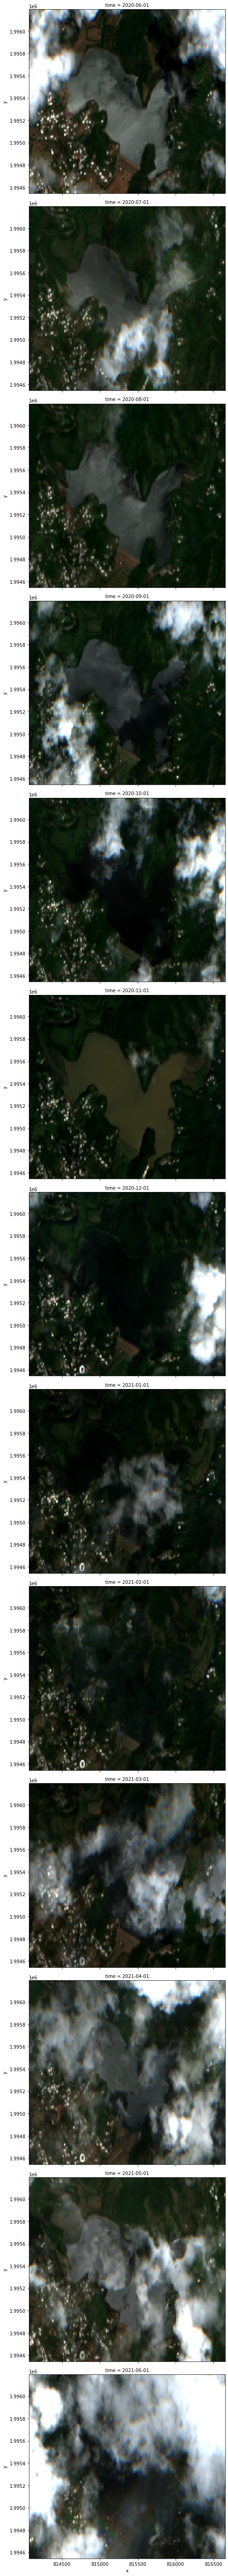

In [14]:
data.plot.imshow(row="time", rgb="band", robust=True, size=6)